In [1]:
from torcheeg.datasets import SEEDDataset
from torcheeg import transforms

raw_dataset = SEEDDataset(
    root_path='./SEED/SEED_EEG/Preprocessed_EEG',
    io_path = 'E:/FYP/Egg-Based Emotion Recognition/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=None,  # Disable transforms
    label_transform=None,
    num_worker=4
)

raw_sample = raw_dataset[0]
print(f"Raw EEG data shape: {raw_sample[0].shape}")  # Should be [62, ...] for SEED

[2024-12-06 21:50:44] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from E:/FYP/Egg-Based Emotion Recognition/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


Raw EEG data shape: (62, 200)


In [2]:
print(raw_dataset[0])

(array([[-19.28210258,  -9.29832458, -25.77900887, ..., -15.55681229,
        -17.49396324, -19.90795135],
       [ 11.92092896,  20.53380013,  11.41428947, ...,   3.21865082,
         -1.16229057,  13.76867294],
       [  0.56624413,  18.80526543, -11.08646393, ..., -26.4942646 ,
        -23.66304398,   8.31484795],
       ...,
       [  3.4570694 ,  10.72883606,  -6.7949295 , ...,  12.54677773,
         10.46061516,  14.42432404],
       [  5.24520874,  11.77191734,  -3.66568565, ...,  15.07997513,
         11.41428947,  20.02716064],
       [  9.08970833,   6.34789467,   1.16229057, ...,  10.37120819,
         12.54677773,  17.94099808]]), {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 10, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0'})


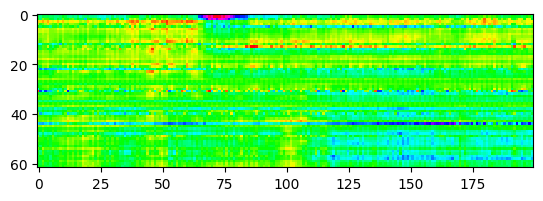

In [3]:
import torch
from torcheeg.utils import plot_2d_tensor

img = plot_2d_tensor(torch.tensor(raw_dataset[0][0]))

In [5]:
import numpy as np
from scipy.signal import butter, lfilter

# Define a bandpass filter (4-47 Hz for SEED dataset)
def bandpass_filter(data, lowcut=4, highcut=47, fs=200, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data, axis=-1)

# Apply bandpass filtering to the raw EEG data
preprocessed_data = bandpass_filter(raw_sample[0])

print(f"Preprocessed EEG data shape: {preprocessed_data.shape}")


Preprocessed EEG data shape: (62, 200)


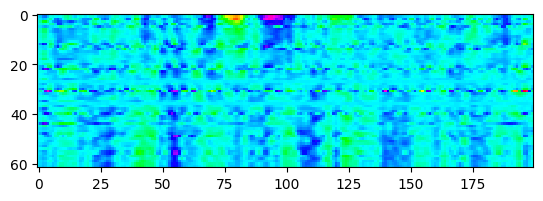

In [5]:
img = plot_2d_tensor(torch.tensor(preprocessed_data))

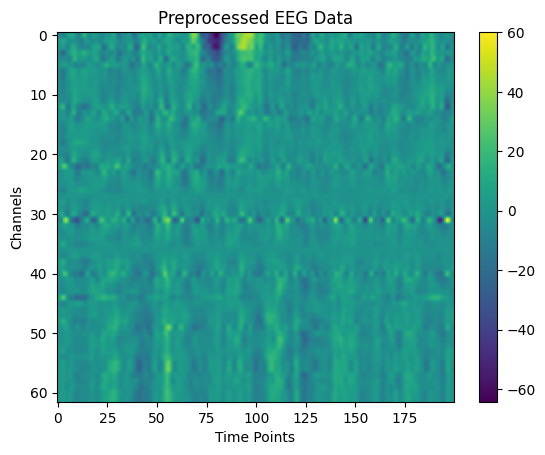

In [6]:
import matplotlib.pyplot as plt

# Visualize the preprocessed EEG data
plt.imshow(preprocessed_data, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Preprocessed EEG Data')
plt.xlabel('Time Points')
plt.ylabel('Channels')
plt.show()


In [7]:
# Perform stratified normalization (z-score)
def stratified_normalization(data):
    normalized_data = (data - np.mean(data, axis=-1, keepdims=True)) / np.std(data, axis=-1, keepdims=True)
    return normalized_data

# Normalize the preprocessed EEG data
normalized_data = stratified_normalization(preprocessed_data)

print(f"Normalized EEG data shape: {normalized_data.shape}")


Normalized EEG data shape: (62, 200)


In [15]:
import torch

def data_sampler(dataset , time_length=30 , step_size=15):
    samples = []
    for sample in dataset:
        data, metadata = sample
        subject_id = metadata['subject_id']
        trial_length = data.shape[1]
        
        for start in range(0, trial_length - time_length + 1, step_size):
            segment = data[: , start:start+time_length]
            samples.append((segment , subject_id))
    return samples

# Define the time length and step size for segmenting the EEG data
time_length = 30  # 30 time points (150 ms) per segment
step_size = 15  # 15 time points (75 ms) step size between segments

segments = data_sampler(raw_dataset, time_length=time_length, step_size=step_size)
print(f"Number of segments: {len(segments)}")
print(f"Segment shape: {segments[0][0].shape} , Subject ID: {segments[0][1]}")


Number of segments: 1832760
Segment shape: (62, 30) , Subject ID: 10


In [16]:
import torch.nn as nn

class BaseEncoder(nn.Module):
    def __init__(self, num_channels=62, spatial_filters=16 , temporal_filter_size=48 , temporal_filters=16):
        super(BaseEncoder, self).__init__()
        
        # Spatial convolutional layer
        self.spatial_conv = nn.Conv1d(in_channels=num_channels,out_channels=spatial_filters,kernel_size=1)
        self.temporal_conv = nn.Conv1d(in_channels=spatial_filters,out_channels=temporal_filters,kernel_size=temporal_filter_size,padding=temporal_filter_size//2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Apply spatial convolution
        x = self.spatial_conv(x)
        x = self.relu(x)
        # Apply temporal convolution
        x = self.temporal_conv(x)
        x = self.relu(x)
        return x
    
#Initialize the encoder
base_encoder = BaseEncoder(num_channels=62, spatial_filters=16, temporal_filter_size=48, temporal_filters=16)

#Test on the sample segment
sample_segment = torch.tensor(segments[0][0], dtype=torch.float32).unsqueeze(0)
encoded_output = base_encoder(sample_segment)

print(f"Sample segment shape: {sample_segment.shape}")
print(f"Encoded output shape: {encoded_output.shape}")
        

Sample segment shape: torch.Size([1, 62, 30])
Encoded output shape: torch.Size([1, 16, 31])


In [17]:
# Define the Projector
class Projector(nn.Module):
    def __init__(self, spatial_filters=16, pooling_kernel=24, temporal_filter_size=4 , c=2):
        super(Projector, self).__init__()
        #Average Pooling
        
        self.avg_pool = nn.AvgPool1d(kernel_size=pooling_kernel , stride=pooling_kernel)
        #spatial convolution        
        self.spatial_conv = nn.Conv1d(in_channels=spatial_filters, out_channels=spatial_filters*c,kernel_size=1)
        #temporal convolution
        self.temporal_conv = nn.Conv1d(in_channels=spatial_filters*c,out_channels=(spatial_filters*c)*c, kernel_size=temporal_filter_size, padding=temporal_filter_size//2)
        #Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        #Applying avg pooling
        x = self.avg_pool(x)
        #Applying spatial convolution
        x = self.spatial_conv(x)
        x = self.relu(x)
        #Applying temporal convolution
        x = self.temporal_conv(x)
        x = self.relu(x)
        return x
    


# Initialize the projector
projector = Projector(spatial_filters=16, pooling_kernel=24, temporal_filter_size=4,c=2)

# Test on the encoded output
projected_output = projector(encoded_output)

print(f"Encoded output shape: {encoded_output.shape}")
print(f"Projected output shape: {projected_output.shape}")

Encoded output shape: torch.Size([1, 16, 31])
Projected output shape: torch.Size([1, 64, 2])


In [18]:
import torch
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, z_i, z_j):
        # Normalize embeddings
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        
        # Compute similarity matrix
        similarities = torch.matmul(z_i, z_j.T) / self.temperature
        
        # Labels for contrastive loss
        batch_size = z_i.size(0)
        labels = torch.arange(batch_size).long().to(z_i.device)
        
        # Cross-entropy loss
        loss = F.cross_entropy(similarities, labels)
        return loss

# Initialize the contrastive loss
contrastive_loss = ContrastiveLoss(temperature=0.5)

#Generate mock positive pairs( outputs from the projector for paired samples)
z_i = projected_output.view(projected_output.size(0), -1)
z_j = projected_output.view(projected_output.size(0), -1)

#Compute the contrastive loss
loss = contrastive_loss(z_i, z_j)
print(f"Contrastive loss: {loss.item()}")

        

Contrastive loss: 0.0


In [19]:
# Generate mock embeddings for testing
batch_size = 4  # Example batch size
feature_dim = 64  # Match the projector's output size

# Create positive pairs (slightly perturbed to simulate similarity)
z_i = torch.rand(batch_size, feature_dim)
z_j = z_i + torch.normal(mean=0, std=0.01, size=z_i.size())  # Add small noise to simulate similarity

# Normalize embeddings
z_i = F.normalize(z_i, dim=1)
z_j = F.normalize(z_j, dim=1)

# Compute contrastive loss
loss = contrastive_loss(z_i, z_j)
print(f"Contrastive loss with mock positive pairs: {loss.item()}")


Contrastive loss with mock positive pairs: 0.9725548028945923


In [20]:
import numpy as np

#function to compute (DE)
def compute_de_features(eeg_data):
    variance = np.var(eeg_data, axis=-1)
    de_features = 0.5 * np.log2(2* np.pi * np.e * variance)
    return de_features

# Compute DE features for the sample segment
aligned_representation = encoded_output.detach().numpy().squeeze()
de_features = compute_de_features(aligned_representation)

print(f"DE features shape: {de_features.shape}")
print(f"DE features: {de_features}")

DE features shape: (16,)
DE features: [       -inf  2.1926346   2.00243     3.037949   -0.10271225  3.308196
  2.112591    1.8291397   1.7693679   1.6866695   2.7851958   2.5211203
  2.8297029   2.0737329   3.1563616   1.4511888 ]


In [21]:
import torch.nn as nn
import torch.optim as optim

class MLPCLassifier(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=30, output_dim=3):
        super(MLPCLassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
# Initialize the classifier
mlp_classifier = MLPCLassifier(input_dim=16, hidden_dim=30, output_dim=3)

#Test the classifier
de_features_tensor = torch.tensor(de_features, dtype=torch.float32).unsqueeze(0)
output = mlp_classifier(de_features_tensor)

print(f"DE features shape: {de_features_tensor.shape}")
print(f"Classifier output shape: {output.shape}")
print(f"Predictied emotion probabilities: {output}")

DE features shape: torch.Size([1, 16])
Classifier output shape: torch.Size([1, 3])
Predictied emotion probabilities: tensor([[nan, nan, nan]], grad_fn=<SoftmaxBackward0>)


In [22]:
import torch.utils.data as data

# Mock Dataset for Training (Replace with actual DE feature dataset)
class DEFeatureDataset(data.Dataset):
    def __init__(self, num_samples=100):
        self.num_samples = num_samples
        self.features = torch.randn(num_samples, 16)  # Random DE features
        self.labels = torch.randint(0, 3, (num_samples,))  # Random labels (3 emotion categories)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Initialize Dataset and DataLoader
dataset = DEFeatureDataset(num_samples=100)
data_loader = data.DataLoader(dataset, batch_size=16, shuffle=True)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_classifier.parameters(), lr=0.001)

# Training Loop
for epoch in range(5):  # Train for 5 epochs
    total_loss = 0
    for batch_features, batch_labels in data_loader:
        optimizer.zero_grad()
        predictions = mlp_classifier(batch_features)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(data_loader)}")


Epoch 1, Loss: 1.1022374289376395
Epoch 2, Loss: 1.0968850340162004
Epoch 3, Loss: 1.0922445740018571
Epoch 4, Loss: 1.0931646142687117
Epoch 5, Loss: 1.0903737545013428


In [23]:
# Evaluation Dataset (Mock Testing Data)
test_dataset = DEFeatureDataset(num_samples=20)  # Smaller dataset for testing
test_loader = data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# Evaluation Loop
mlp_classifier.eval()  # Set the classifier to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        predictions = mlp_classifier(batch_features)
        predicted_labels = torch.argmax(predictions, dim=1)
        correct += (predicted_labels == batch_labels).sum().item()
        total += batch_labels.size(0)

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 25.00%


APPLICATION TO WHOLE DATA

In [6]:
# Function to process the entire dataset
def process_dataset(dataset):
    processed_segments = []
    for sample in dataset:
        eeg_data, metadata = sample

        # Bandpass filter
        filtered_data = bandpass_filter(eeg_data)

        # Append metadata for reference
        processed_segments.append((filtered_data, metadata))

    return processed_segments

# Process the raw dataset
processed_data = process_dataset(raw_dataset)
print(f"Processed {len(processed_data)} EEG samples.")
print(f"First processed sample shape: {processed_data[0][0].shape}")

Processed 152730 EEG samples.
First processed sample shape: (62, 200)


Checking for Artifacts

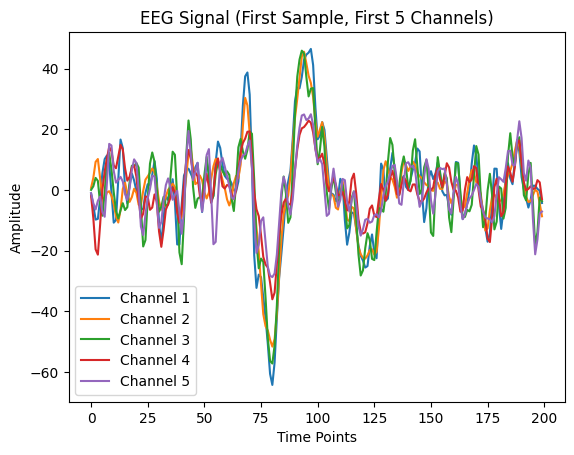

In [25]:
import matplotlib.pyplot as plt

# Visualize EEG signal for the first sample and first 5 channels
eeg_data, _ = processed_data[0]  # Replace with normalized_data if already normalized
for channel in range(5):  # Visualize first 5 channels
    plt.plot(eeg_data[channel, :], label=f'Channel {channel+1}')
plt.title('EEG Signal (First Sample, First 5 Channels)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [26]:
# Compute variance across time points for each channel
eeg_data, _ = processed_data[0]
variance = np.var(eeg_data, axis=1)
print(f'Variance across channels: {variance}')

# Flag channels with unusually high variance
threshold = np.mean(variance) + 3 * np.std(variance)  # 3-sigma rule
artifact_channels = np.where(variance > threshold)[0]
print(f'Channels with artifacts: {artifact_channels}')


Variance across channels: [2.88711124e+02 2.18970653e+02 2.39640774e+02 9.92589084e+01
 1.03980378e+02 6.59008687e+01 5.36339461e+01 3.75502305e+01
 3.17774269e+01 3.08489418e+01 3.45634075e+01 4.07416981e+01
 7.47830643e+01 5.56228761e+01 7.56380017e+01 3.47239044e+01
 1.75527078e+01 1.10857114e+01 1.47321980e+01 1.08047042e+01
 2.32862554e+01 5.71502909e+01 8.13472500e+01 5.19968752e+01
 2.90521157e+01 1.67339063e+01 9.67938366e+00 1.79470810e-01
 6.10604941e+00 1.75851697e+01 6.74993834e+01 3.16524470e+02
 3.82455975e+01 2.45000311e+01 1.68617385e+01 1.09527791e+01
 1.60944414e-01 8.10107852e+00 2.59409116e+01 3.52847480e+01
 9.64959093e+01 4.23698233e+01 3.60389108e+01 2.61315133e+01
 6.39326734e+01 1.30697148e+01 1.84383763e+01 3.47911670e+01
 5.46073495e+01 7.45168250e+01 4.60223185e+01 4.80595469e+01
 3.57531413e+01 2.93699280e+01 4.23142032e+01 6.74216867e+01
 7.09997871e+01 4.97636229e+01 4.03753037e+01 4.10292845e+01
 4.82002698e+01 5.01593071e+01]
Channels with artifacts: [ 

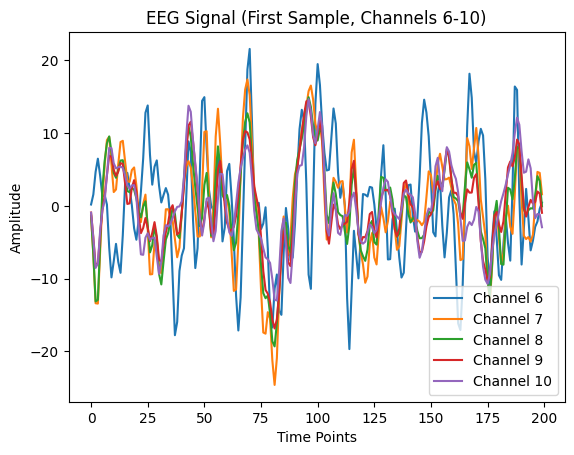

In [27]:
# Visualize next 5 channels of the first sample
for channel in range(5, 10):  # Channels 6 to 10
    plt.plot(eeg_data[channel, :], label=f'Channel {channel+1}')
plt.title('EEG Signal (First Sample, Channels 6-10)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [28]:
# Compute variance for the first sample
variance = np.var(eeg_data, axis=1)
print(f'Variance across channels: {variance}')


Variance across channels: [2.88711124e+02 2.18970653e+02 2.39640774e+02 9.92589084e+01
 1.03980378e+02 6.59008687e+01 5.36339461e+01 3.75502305e+01
 3.17774269e+01 3.08489418e+01 3.45634075e+01 4.07416981e+01
 7.47830643e+01 5.56228761e+01 7.56380017e+01 3.47239044e+01
 1.75527078e+01 1.10857114e+01 1.47321980e+01 1.08047042e+01
 2.32862554e+01 5.71502909e+01 8.13472500e+01 5.19968752e+01
 2.90521157e+01 1.67339063e+01 9.67938366e+00 1.79470810e-01
 6.10604941e+00 1.75851697e+01 6.74993834e+01 3.16524470e+02
 3.82455975e+01 2.45000311e+01 1.68617385e+01 1.09527791e+01
 1.60944414e-01 8.10107852e+00 2.59409116e+01 3.52847480e+01
 9.64959093e+01 4.23698233e+01 3.60389108e+01 2.61315133e+01
 6.39326734e+01 1.30697148e+01 1.84383763e+01 3.47911670e+01
 5.46073495e+01 7.45168250e+01 4.60223185e+01 4.80595469e+01
 3.57531413e+01 2.93699280e+01 4.23142032e+01 6.74216867e+01
 7.09997871e+01 4.97636229e+01 4.03753037e+01 4.10292845e+01
 4.82002698e+01 5.01593071e+01]


In [29]:
# Remove artifact channels
artifact_free_data = np.delete(eeg_data, [0, 2, 31], axis=0)  # Remove channels 0, 2, and 31
print(f"Shape after removing artifact channels: {artifact_free_data.shape}")


Shape after removing artifact channels: (59, 200)


In [30]:
# Recompute variance
updated_variance = np.var(artifact_free_data, axis=1)
print(f"Updated variance across channels: {updated_variance}")


Updated variance across channels: [2.18970653e+02 9.92589084e+01 1.03980378e+02 6.59008687e+01
 5.36339461e+01 3.75502305e+01 3.17774269e+01 3.08489418e+01
 3.45634075e+01 4.07416981e+01 7.47830643e+01 5.56228761e+01
 7.56380017e+01 3.47239044e+01 1.75527078e+01 1.10857114e+01
 1.47321980e+01 1.08047042e+01 2.32862554e+01 5.71502909e+01
 8.13472500e+01 5.19968752e+01 2.90521157e+01 1.67339063e+01
 9.67938366e+00 1.79470810e-01 6.10604941e+00 1.75851697e+01
 6.74993834e+01 3.82455975e+01 2.45000311e+01 1.68617385e+01
 1.09527791e+01 1.60944414e-01 8.10107852e+00 2.59409116e+01
 3.52847480e+01 9.64959093e+01 4.23698233e+01 3.60389108e+01
 2.61315133e+01 6.39326734e+01 1.30697148e+01 1.84383763e+01
 3.47911670e+01 5.46073495e+01 7.45168250e+01 4.60223185e+01
 4.80595469e+01 3.57531413e+01 2.93699280e+01 4.23142032e+01
 6.74216867e+01 7.09997871e+01 4.97636229e+01 4.03753037e+01
 4.10292845e+01 4.82002698e+01 5.01593071e+01]


Moving towards normalization
The next step is to normalize the data. Normalization is a process of scaling the data to a

In [7]:
import numpy as np

def incremental_normalization(process_dataset):
    normalized_segments = []
    subject_data_stats = {}
    
    #First pass : computing mean and variance incrementally for each subject
    for eeg_data, metadata in process_dataset:
        subject_id = metadata['subject_id']
        if subject_id not in subject_data_stats:
            subject_data_stats[subject_id] = {'sum':0, 'sum_sq':0, "count":0}
            
        stats = subject_data_stats[subject_id]
        stats['sum'] += np.sum(eeg_data, axis=-1, keepdims=True)
        stats['sum_sq'] += np.sum(eeg_data**2, axis=-1, keepdims=True)
        stats['count'] += eeg_data.shape[1]
        
    #Compute mean and standard deviation for each subject
    for subject_id, stats in subject_data_stats.items():
        stats['mean'] = stats['sum'] / stats['count']
        stats['std'] = np.sqrt(stats['sum_sq'] / stats['count'] - stats['mean']**2)
        
        
    #Second pass : Normalizing each segment using computed stats
    for eeg_data, metadata in process_dataset:
        subject_id = metadata['subject_id']
        stats = subject_data_stats[subject_id]
        mean = stats['mean']
        std = stats['std']
        normalized_data = (eeg_data - mean) / std
        normalized_segments.append((normalized_data, metadata))
        
    return normalized_segments

# Normalize the processed dataset
normalized_data = incremental_normalization(processed_data)

#output the normalized data
print(f"Normalized {len(normalized_data)} EEG samples.")
print(f"First normalized sample shape: {normalized_data[0][0].shape}")
        
        

Normalized 152730 EEG samples.
First normalized sample shape: (62, 200)


Data Sampling

In [16]:
# Function to sample data into fixed length segments
def sample_data(normalized_data, time_length=30, step_size=15):
    sampled_segments = []
    
    for eeg_data, metadata in normalized_data:
        trial_length = eeg_data.shape[1]
        
        for start in range(0 , trial_length - time_length + 1, step_size):
            segment = eeg_data[:, start:start+time_length]
            new_metadata = metadata.copy()
            new_metadata['segment_start'] = start
            new_metadata['segment_end'] = start + time_length
            sampled_segments.append((segment, new_metadata))
    
    return sampled_segments

# Sample the normalized data
time_length = 30
step_size = 15
sampled_data = sample_data(normalized_data, time_length=time_length, step_size=step_size)
            
# Output the sampled data
print(f"Generated {len(sampled_data)} EEG segments.")
print(f"First sampled segment shape: {sampled_data[0][0].shape}")

Generated 1832760 EEG segments.
First sampled segment shape: (62, 30)


In [17]:
# Function to compute DE features for each segment
def compute_de_features(eeg_segments):
    # eeg_segment shape: [channels, timepoints]
    variance = np.var(eeg_segments, axis=-1)
    de_features = 0.5 * np.log2(2 * np.pi * np.e * variance)
    return de_features

# Extract DE features for the sampled data
de_features_data = []
for segment, metadata in sampled_data:
    de_features = compute_de_features(segment)
    de_features_data.append((de_features, metadata))
    
# Output the DE features data
print(f"Computed DE features for {len(de_features_data)} EEG segments.")
print(f"First DE features shape: {de_features_data[0][0].shape}")

Computed DE features for 1832760 EEG segments.
First DE features shape: (62,)


In [18]:
import torch.nn as nn

class BaseEncoder(nn.Module):
    def __init__(self, input_channels=62, temporal_filter_length=48, spatial_filters=16, temporal_filters=16):
        super(BaseEncoder, self).__init__()
        # Spatial Convolution
        self.spatial_conv = nn.Conv1d(input_channels, spatial_filters, kernel_size=1)
        # Temporal Convolution
        self.temporal_conv = nn.Conv1d(spatial_filters, temporal_filters, kernel_size=temporal_filter_length, padding=temporal_filter_length // 2)

    def forward(self, x):
        # x shape: [batch_size, input_channels, time_points]
        print("Entered BaseEncoder")
        x = self.spatial_conv(x)
        x = nn.ReLU()(x)
        x = self.temporal_conv(x)
        x = nn.ReLU()(x)
        print("Exit BaseEncoder")
        return x


In [19]:
# Instantiate the base encoder
base_encoder = BaseEncoder(input_channels=62, temporal_filter_length=48, spatial_filters=16, temporal_filters=16)

# Create a mock EEG sample
sample_segment = torch.randn(1, 62, 30)  # Shape: [batch_size, input_channels, time_points]

# Pass the sample through the base encoder
encoded_output = base_encoder(sample_segment)

# Output the shape and sample values
print(f"Encoded output shape: {encoded_output.shape}")
print(f"Sample encoded output (first 5 channels): {encoded_output[0, :, :5]}")


Entered BaseEncoder
Exit BaseEncoder
Encoded output shape: torch.Size([1, 16, 31])
Sample encoded output (first 5 channels): tensor([[0.0000, 0.2231, 0.0890, 0.0000, 0.0964],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1257],
        [0.1435, 0.0277, 0.2629, 0.0000, 0.0000],
        [0.0000, 0.0158, 0.0000, 0.0228, 0.0000],
        [0.0000, 0.0000, 0.0264, 0.0000, 0.0161],
        [0.0395, 0.0254, 0.0000, 0.2917, 0.0980],
        [0.0000, 0.0069, 0.3017, 0.0564, 0.0000],
        [0.0000, 0.0000, 0.0547, 0.0000, 0.0000],
        [0.0000, 0.1138, 0.3318, 0.0863, 0.2381],
        [0.0000, 0.0575, 0.0237, 0.0000, 0.1973],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3192, 0.0975, 0.3419, 0.0000, 0.0000],
        [0.0546, 0.0078, 0.0000, 0.0000, 0.3408],
        [0.0296, 0.0000, 0.0000, 0.0000, 0.0595],
        [0.0406, 0.0755, 0.2397, 0.3373, 0.2540]], grad_fn=<SliceBackward0>)


In [20]:
# Define the Projector
class Projector(nn.Module):
    def __init__(self, spatial_filters=16, pooling_kernel=24, temporal_filter_size=4 , c=2):
        super(Projector, self).__init__()
        #Average Pooling
        
        self.avg_pool = nn.AvgPool1d(kernel_size=pooling_kernel , stride=pooling_kernel)
        #spatial convolution        
        self.spatial_conv = nn.Conv1d(in_channels=spatial_filters, out_channels=spatial_filters*c,kernel_size=1)
        #temporal convolution
        self.temporal_conv = nn.Conv1d(in_channels=spatial_filters*c,out_channels=(spatial_filters*c)*c, kernel_size=temporal_filter_size, padding=temporal_filter_size//2)
        #Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        print("Entered Projector")
        #Applying avg pooling
        x = self.avg_pool(x)
        #Applying spatial convolution
        x = self.spatial_conv(x)
        x = self.relu(x)
        #Applying temporal convolution
        x = self.temporal_conv(x)
        x = self.relu(x)
        print("Exit Projector")
        return x
    


# Initialize the projector
projector = Projector(spatial_filters=16, pooling_kernel=24, temporal_filter_size=4,c=2)

# Test on the encoded output
projected_output = projector(encoded_output)

print(f"Encoded output shape: {encoded_output.shape}")
print(f"Projected output shape: {projected_output.shape}")

Entered Projector
Exit Projector
Encoded output shape: torch.Size([1, 16, 31])
Projected output shape: torch.Size([1, 64, 2])


In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=1.0):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        print("Entered ContrastiveLoss")
        
        # Normalize embeddings
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)

        # Debugging normalization
        print(f"z_i Mean: {z_i.mean().item()}, Std: {z_i.std().item()}")
        print(f"z_j Mean: {z_j.mean().item()}, Std: {z_j.std().item()}")

        # Compute similarity matrix
        similarities = torch.matmul(z_i, z_j.T) / self.temperature

        # Clamp similarities to prevent overflow in exp
        similarities = torch.clamp(similarities, min=-5, max=5)
        
        # Debugging similarities
        print(f"Similarities: {similarities[:5, :5]}")
        print(f"Similarities Range: [{similarities.min().item()}, {similarities.max().item()}]")

        # Create labels for contrastive loss
        # batch_size = z_i.size(0)
        batch_size = similarities.size(0).to(similarities.device)
        # labels = torch.arange(batch_size).to(z_i.device)
        labels = torch.arange(batch_size).to(similarities.device)
        print(f"Labels: {labels[:5]}")

        # Check for NaNs/Infs before computing loss
        if torch.isnan(similarities).any() or torch.isinf(similarities).any():
            print("NaN or Inf detected in similarities")

        # Compute cross-entropy loss
        loss = nn.CrossEntropyLoss()(similarities, labels)
        
        print(f"Exit ContrastiveLoss with Loss: {loss.item()}")
        return loss


In [281]:
# Sample data
batch_size = 4
embedding_dim = 128

# Simulate output embeddings from the projector for two augmented views
z_A = torch.randn(batch_size, embedding_dim)
z_B = torch.randn(batch_size, embedding_dim)

# Initialize the contrastive loss
contrastive_loss = ContrastiveLoss(temperature=0.7)

# Compute the loss
loss = contrastive_loss(z_A, z_B)

print(f"Contrastive Loss: {loss.item()}")


Entered ContrastiveLoss
z_i Mean: 0.0008723717764951289, Std: 0.08847048133611679
z_j Mean: 0.00018321722745895386, Std: 0.08847460150718689
Similarities: tensor([[-1.5923e-02,  1.8144e-02,  3.0793e-02,  5.4898e-02],
        [ 2.1284e-01, -5.5849e-02, -2.0748e-02, -2.5636e-02],
        [-3.0704e-01, -1.1834e-04,  1.8439e-01, -1.3120e-02],
        [-1.9545e-01,  9.5966e-02, -9.7414e-02,  2.1207e-02]])
Similarities Range: [-0.3070354461669922, 0.21284393966197968]
Labels: tensor([0, 1, 2, 3])
Exit ContrastiveLoss with Loss: 1.3526623249053955
Contrastive Loss: 1.3526623249053955


In [23]:
# Check unique subject IDs and their sample counts
from collections import Counter

subject_ids = [item[1]['subject_id'] for item in sampled_data]
subject_distribution = Counter(subject_ids)

print(f"Unique Subject IDs: {list(subject_distribution.keys())}")
print(f"Subject Sample Counts: {subject_distribution}")

# Create a mapping for subject IDs
unique_subject_ids = sorted(set(subject_ids))
subject_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_subject_ids)}

# Update subject IDs in metadata
for _, metadata in sampled_data:
    metadata['subject_id'] = subject_id_map[metadata['subject_id']]

# Verify remapping
updated_subject_ids = [item[1]['subject_id'] for item in sampled_data]
updated_subject_distribution = Counter(updated_subject_ids)

print(f"Updated Subject IDs: {list(updated_subject_distribution.keys())}")
print(f"Updated Subject Sample Counts: {updated_subject_distribution}")


Unique Subject IDs: [10, 11, 12, 13, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Subject Sample Counts: Counter({10: 122184, 11: 122184, 12: 122184, 13: 122184, 14: 122184, 15: 122184, 1: 122184, 2: 122184, 3: 122184, 4: 122184, 5: 122184, 6: 122184, 7: 122184, 8: 122184, 9: 122184})
Updated Subject IDs: [9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8]
Updated Subject Sample Counts: Counter({9: 122184, 10: 122184, 11: 122184, 12: 122184, 13: 122184, 14: 122184, 0: 122184, 1: 122184, 2: 122184, 3: 122184, 4: 122184, 5: 122184, 6: 122184, 7: 122184, 8: 122184})


In [24]:
def loso_split(dataset, num_subjects):
    """
    Create training and testing splits for Leave-One-Subject-Out (LOSO) Cross-Validation.
    Args:
        dataset: list of tuples (EEG_data, metadata)
        num_subjects: total number of unique subjects in the dataset
    Returns:
        List of splits [(train_data, test_data), ...]
    """
    splits = []
    for test_subject in range(num_subjects):
        # Split dataset into training and testing based on subject ID
        train_data = [item for item in dataset if item[1]['subject_id'] != test_subject]
        test_data = [item for item in dataset if item[1]['subject_id'] == test_subject]
        splits.append((train_data, test_data))
    return splits

# Determine the number of unique subjects
num_subjects = len(set(item[1]['subject_id'] for item in sampled_data))

# Perform LOSO split
loso_splits = loso_split(sampled_data, num_subjects)

# Example: Use the first split
train_data, test_data = loso_splits[0]
print(f"Training samples: {len(train_data)}, Testing samples: {len(test_data)}")


Training samples: 1710576, Testing samples: 122184


Inspecting Training and Test Data

In [25]:
# Extract unique subject IDs in training and testing data
train_subjects = set(item[1]['subject_id'] for item in train_data)
test_subjects = set(item[1]['subject_id'] for item in test_data)

print(f"Training Subject IDs: {train_subjects}")
print(f"Testing Subject IDs: {test_subjects}")


Training Subject IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
Testing Subject IDs: {0}


In [26]:
# Inspect a random training sample
random_train_sample = train_data[0]
print(f"Random Training Sample Shape: {random_train_sample[0].shape}")
print(f"Random Training Sample Metadata: {random_train_sample[1]}")

# Inspect a random test sample
random_test_sample = test_data[0]
print(f"Random Test Sample Shape: {random_test_sample[0].shape}")
print(f"Random Test Sample Metadata: {random_test_sample[1]}")


Random Training Sample Shape: (62, 30)
Random Training Sample Metadata: {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 9, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0', 'segment_start': 0, 'segment_end': 30}
Random Test Sample Shape: (62, 30)
Random Test Sample Metadata: {'start_at': 0, 'end_at': 200, 'clip_id': '1_20131027.mat_0', 'subject_id': 0, 'trial_id': 'djc_eeg1', 'emotion': 1, 'date': 20131027, '_record_id': '_record_18', 'segment_start': 0, 'segment_end': 30}


In [27]:
from collections import Counter

# Check label distribution
train_labels = [item[1]['emotion'] for item in train_data]  # Replace 'emotion' with the actual key for emotion labels
test_labels = [item[1]['emotion'] for item in test_data]

print(f"Training Label Distribution: {Counter(train_labels)}")
print(f"Testing Label Distribution: {Counter(test_labels)}")


Training Label Distribution: Counter({1: 589680, -1: 564480, 0: 556416})
Testing Label Distribution: Counter({1: 42120, -1: 40320, 0: 39744})


Saving the data for later usage

In [ ]:
import h5py
import numpy as np

def save_to_hdf5(data, filename):
    """
    Save processed EEG data to an HDF5 file.
    Args:
        data: List of tuples (eeg_data, metadata)
        filename: Name of the HDF5 file
    """
    with h5py.File(filename, "w") as h5file:
        for i, (eeg_data, metadata) in enumerate(data):
            # Create a group for each sample
            group = h5file.create_group(str(i))
            # Save EEG data
            group.create_dataset("eeg_data", data=eeg_data)
            # Save metadata
            for key, value in metadata.items():
                group.attrs[key] = value

# Save training and testing data
save_to_hdf5(train_data, "./Data/Train/train_data_processed.h5")
save_to_hdf5(test_data, "./Data/Test/test_data_processed.h5")

print("Processed data saved successfully!")


In [ ]:
import h5py
import numpy as np

def load_from_hdf5(filename):
    """
    Load processed EEG data from an HDF5 file.
    Args:
        filename: Name of the HDF5 file
    Returns:
        Loaded data as a list of tuples (eeg_data, metadata)
    """
    data = []
    with h5py.File(filename, "r") as h5file:
        for key in h5file.keys():
            # Load EEG data
            eeg_data = np.array(h5file[key]["eeg_data"])
            # Load metadata
            metadata = dict(h5file[key].attrs)
            data.append((eeg_data, metadata))
    return data



In [ ]:
# Load training and testing data from HDF5
train_data = load_from_hdf5("./Data/Train/train_data_processed.h5")
test_data = load_from_hdf5("./Data/Test/test_data_processed.h5")

# Verify loaded data
print(f"Loaded {len(train_data)} training samples and {len(test_data)} testing samples.")
print(f"First Training Sample Shape: {train_data[0][0].shape}")
print(f"First Training Sample Metadata: {train_data[0][1]}")


MODELLING

In [28]:
# Check the first few samples in your dataset
print(f"Total samples: {len(train_data)}")
for i in range(5):  # Check the first 5 samples
    eeg_data, metadata = train_data[i]
    print(f"Sample {i}: EEG Shape = {eeg_data.shape}, Metadata = {metadata}")


Total samples: 1710576
Sample 0: EEG Shape = (62, 30), Metadata = {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 9, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0', 'segment_start': 0, 'segment_end': 30}
Sample 1: EEG Shape = (62, 30), Metadata = {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 9, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0', 'segment_start': 15, 'segment_end': 45}
Sample 2: EEG Shape = (62, 30), Metadata = {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 9, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0', 'segment_start': 30, 'segment_end': 60}
Sample 3: EEG Shape = (62, 30), Metadata = {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 9, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0', 'segment_start': 45, 'segment_end': 75

In [123]:
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch

class EEGDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # print("Entered EEGDataset")
        eeg_data, metadata = self.data[idx]
        if not isinstance(metadata, dict):
            raise ValueError(f"Metadata must be a dictionary, but got {type(metadata)} at index {idx}.")
        eeg_data_tensor = torch.tensor(eeg_data, dtype=torch.float32)
        emotion_label = metadata.get('emotion', -1) # Replace 'emotion' with the actual key for emotion labels
        # print("Exit EEGDataset")
        return eeg_data_tensor, metadata

In [128]:
train_dataset = EEGDataset(train_data)

# Access a few samples
for i in range(5):
    eeg_data, label = train_dataset[i]
    print(f"Sample {i}: Data Shape = {eeg_data.shape}, Label = {label}")


Sample 0: Data Shape = torch.Size([62, 30]), Label = {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 9, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0', 'segment_start': 0, 'segment_end': 30}
Sample 1: Data Shape = torch.Size([62, 30]), Label = {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 9, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0', 'segment_start': 15, 'segment_end': 45}
Sample 2: Data Shape = torch.Size([62, 30]), Label = {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 9, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0', 'segment_start': 30, 'segment_end': 60}
Sample 3: Data Shape = torch.Size([62, 30]), Label = {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 9, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0', 'segment_start': 45, 

In [129]:
train_dataset = EEGDataset(train_data)
test_dataset = EEGDataset(test_data)


In [130]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)

for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}: Data Shape = {batch_data.shape}, Labels = {batch_labels}")
    if batch_idx == 5:  # Limit to the first 5 batches
        break


Batch 0: Data Shape = torch.Size([256, 62, 30]), Labels = {'start_at': tensor([36000,  5200,  7800, 23800, 21400, 37000,  1200, 12600, 16200, 37000,
        16800,   600, 31600,  9200, 27600, 42400, 26400, 18800, 15200, 42400,
        31600, 44200, 18400, 21000, 45800,   200, 17800, 30600,   800, 17600,
        15000, 43000, 18600, 46600, 19400, 28800, 12000, 45800, 26000, 37400,
        16600, 23400,  7400,  7000, 24400, 45600, 23000, 21800,  6600, 24600,
        10400, 46400,  2600, 11000, 31200, 14400,  4600,  3400, 16000, 35800,
        23200, 16400, 10200, 23400, 31800, 13800, 28400,  4400, 15200,  4400,
        35000, 32000, 31200,  3000, 19400, 32400, 29400, 31200, 13800, 26000,
        21800, 21200, 31000, 42600, 11600, 35000, 40600, 28600, 32600, 17000,
        10000, 45000, 12000, 14400, 35400,  6200, 43200, 31800, 24600, 22600,
        35200, 14400, 34000, 35000, 11400,  7400, 19600, 31200, 17000, 42800,
         9200,   200, 34800, 28800, 23000, 40200, 20600,  4600,     0, 

NEED TO RUN THESE

In [ ]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)


Train Dataloader:


In [62]:
eeg_sample, label = train_dataset[0]
print(f"Sample shape: {eeg_sample.shape}, Label: {label}")


Sample shape: torch.Size([62, 30]), Label: 1


Already ran

In [205]:
def stratified_normalization_minibatch(x, metadata):
    """
    Perform stratified normalization of the minibatch based on subject and emotion information.
    x: Tensor of shape [batch_size, channels, time_points].
    metadata: Dictionary of metadata with keys like 'subject_id', 'emotion', etc.
    """
    print("Entered stratified_normalization_minibatch")
    print(f"x.shape: {x.shape}")
    print(f"Metadata keys: {list(metadata.keys())}")

    # Extract subject_id and emotion as tensors
    subject_ids = metadata['subject_id']
    emotion_labels = metadata['emotion']

    # Initialize normalized tensor
    normalized_x = torch.zeros_like(x)

    # Group data by (subject_id, emotion)
    group_to_indices = {}
    for idx, (subject, emotion) in enumerate(zip(subject_ids, emotion_labels)):
        group = (subject.item(), emotion.item())
        if group not in group_to_indices:
            group_to_indices[group] = []
        group_to_indices[group].append(idx)

    for group, indices in group_to_indices.items():
        group_data = x[indices]  # Extract data for the group
        mean = group_data.mean(dim=-1, keepdim=True)  # Mean over time points
        std = group_data.std(dim=-1, keepdim=True)    # Std over time points
        normalized_x[indices] = (group_data - mean) / (std + 1e-8)  # Normalize

    print("Exit stratified_normalization_minibatch")
    return normalized_x


In [206]:
for batch_data, batch_labels in train_loader:
    print(f"Original Batch Shape: {batch_data.shape}, Metadata: {batch_labels}")

    normalized_data = stratified_normalization_minibatch(batch_data, batch_labels)
    print(f"Normalized Batch Shape: {normalized_data.shape}")
    break


Original Batch Shape: torch.Size([256, 62, 30]), Metadata: {'start_at': tensor([14800, 16600, 33800,  6800, 16200, 35000, 42400, 35800, 35200, 24200,
        38200, 50400, 30200,  9200,  8600, 43000, 29000, 40200, 15800,  4200,
        19400, 17400, 29000, 39200, 27000, 37400, 45200, 43800, 41200, 28400,
        26200,  1600, 25800, 30600, 46200, 10800, 12800, 40000,  3200, 34200,
        23600, 46400, 20000,  2400, 27200,  3000, 34800, 15600, 27800, 19000,
        41400, 30400, 19200, 36200, 18600,  2600, 10800,  6000,     0, 28600,
        11800, 17600, 19400, 42000,  1600, 38400,  8200, 44800,  8800, 23200,
        34200,  6800, 16000, 10800, 30400, 20200,  2800, 29000, 39000,  9400,
         3800, 31800, 10400, 46600, 29800, 39200, 13200, 21200, 14400, 13600,
        37600, 12000, 24000, 25800,   200,  7200, 16800, 28200, 20200, 39400,
        12800, 34000, 42400, 22200, 33200, 23800,  4400, 38400, 27200, 32200,
        17600, 33800, 33800, 43600, 31400, 39000,  4200, 42400, 22800,

In [208]:
for batch_data, batch_labels in train_loader:
    print(f"Original Batch Shape: {batch_data.shape}")
    normalized_data = stratified_normalization_minibatch(batch_data, batch_labels)
    print(f"Normalized Batch Shape: {normalized_data.shape}")
    break


Original Batch Shape: torch.Size([256, 62, 30])
Entered stratified_normalization_minibatch
x.shape: torch.Size([256, 62, 30])
Metadata keys: ['start_at', 'end_at', 'clip_id', 'subject_id', 'trial_id', 'emotion', 'date', '_record_id', 'segment_start', 'segment_end']
Exit stratified_normalization_minibatch
Normalized Batch Shape: torch.Size([256, 62, 30])


In [209]:
import os
import torch

def save_checkpoint(epoch, model, optimizer, loss, path="./Checkpoints/"):
    # Ensure the directory exists
    if not os.path.exists(path):
        os.makedirs(path)
    
    save_path = os.path.join(path, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, save_path)
    print(f"Checkpoint saved at: {save_path}")


In [210]:
def load_checkpoint(filename, model, optimizer):
    """
    Load a training checkpoint.
    Args:
        filename: Name of the checkpoint file.
        model: The model to load the state into.
        optimizer: The optimizer to load the state into.
    Returns:
        epoch: The epoch at which the checkpoint was saved.
        loss: The loss value at the time of saving.
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: {filename} (epoch {epoch})")
    return epoch, loss


In [211]:
def collate_fn(batch):
    eeg_data_batch = torch.stack([item[0] for item in batch])  # Combine data tensors
    metadata_batch = [item[1] for item in batch]  # Collect metadata dictionaries
    return eeg_data_batch, metadata_batch


In [284]:
import os
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

def train_model_with_stratified_normalization(train_data, base_encoder, projector, contrastive_loss, epochs=100, batch_size=256, lr=0.0007, patience=30, checkpoint_path="./Checkpoints/"):
   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    writer = SummaryWriter(log_dir="E:/FYP/Egg-Based Emotion Recognition/EEg-based-Emotion-Recognition/runs/ContrastiveLearning")
    
    checkpoint_dir = "./Checkpoints/"
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    train_dataset = EEGDataset(train_data)
    print(f"Total samples in Dataset: {len(train_dataset)}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, timeout=0)
    print(f"Total batches in DataLoader: {len(train_loader)}")

    # Optimizer and scheduler
    model_params = list(base_encoder.parameters()) + list(projector.parameters())
    optimizer = optim.Adam(model_params, lr=lr, weight_decay=0.015)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    base_encoder.train()
    projector.train()

    best_loss = float("inf")
    epochs_no_improve = 0
    
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        start_epoch, best_loss = load_checkpoint(checkpoint_path, base_encoder, optimizer)
        

    for epoch in range(start_epoch,epochs):
        print(f"Entered Epoch {epoch + 1}")
        total_loss = 0.0
        print(f"Starting Training Loop with {len(train_loader)} batches.")


        for batch_idx, (x, metadata) in enumerate(train_loader):
            print(f"Processing Batch {batch_idx + 1}/{len(train_loader)}")
            print(f"Batch {batch_idx + 1} loaded: x.shape={x.shape}, metadata keys = {list(metadata.keys())}")
           
            print("Entering try block")
            try:
                print("Inside try block")
                x = x.float().to(device)  # Send input to device
              
                # Apply stratified normalization on the minibatch
                x = stratified_normalization_minibatch(x, metadata)
                print(f"Normalized Input Shape: {x.shape}")

                # Forward pass through Base Encoder and Projector
                encoded = base_encoder(x)
                print(f"Encoded Output Shape: {encoded.shape}")
                
                z_i = projector(encoded)
                print(f"Projected z_i Shape: {z_i.shape}")
                
                z_j = projector(encoded + torch.normal(mean=0, std=0.7, size=encoded.shape).to(device))  
                print(f"Projected z_j Shape: {z_j.shape}")
                
                z_i = z_i.view(z_i.size(0), -1)
                z_j = z_j.view(z_j.size(0), -1)

                # Compute Contrastive Loss
                loss = contrastive_loss(z_i,z_j)  # Replace second projected with positive pairs if applicable
                print(f"Batch {batch_idx + 1}, Loss: {loss.item()}")
                
                total_loss += loss.item()
                writer.add_scalar("Batch Loss", loss.item(), epoch * len(train_loader) + batch_idx)

                # Backpropagation and optimization step
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model_params, max_norm=1.0)
                optimizer.step()
                
            except Exception as e:
                print(f"Error in Batch {batch_idx + 1}: {e}")
                break
                      

        # Average loss over all batches
        avg_loss = total_loss / len(train_loader)
        writer.add_scalar("Training Loss", avg_loss, epoch)
        
        if epoch % 5 == 0 or avg_loss < best_loss:
            save_checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
            # save_checkpoint(epoch, base_encoder, optimizer, avg_loss, save_checkpoint_path)

        
            
        # Early stopping logic
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Step the scheduler
        scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    writer.close()
    print("Training complete!")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize models
base_encoder = BaseEncoder(input_channels=62, temporal_filter_length=48, spatial_filters=16, temporal_filters=16).to(device)
projector = Projector(spatial_filters=16, pooling_kernel=24, temporal_filter_size=4, c=2).to(device)
contrastive_loss = ContrastiveLoss(temperature=0.7).to(device)

# Train with stratified normalization
train_model_with_stratified_normalization(
    train_data[:10000], base_encoder, projector, contrastive_loss, epochs=10, batch_size=256, lr=0.0007, patience=30 , checkpoint_path="./Checkpoints/check/"
)


Total samples in Dataset: 10000
Total batches in DataLoader: 157
Entered Epoch 1
Starting Training Loop with 157 batches.
Processing Batch 1/157
Batch 1 loaded: x.shape=torch.Size([64, 62, 30]), metadata keys = ['start_at', 'end_at', 'clip_id', 'subject_id', 'trial_id', 'emotion', 'date', '_record_id', 'segment_start', 'segment_end']
Entering try block
Inside try block
Entered stratified_normalization_minibatch
x.shape: torch.Size([64, 62, 30])
Metadata keys: ['start_at', 'end_at', 'clip_id', 'subject_id', 'trial_id', 'emotion', 'date', '_record_id', 'segment_start', 'segment_end']
Exit stratified_normalization_minibatch
Normalized Input Shape: torch.Size([64, 62, 30])
Entered BaseEncoder
Exit BaseEncoder
Encoded Output Shape: torch.Size([64, 16, 31])
Entered Projector
Exit Projector
Projected z_i Shape: torch.Size([64, 64, 2])
Entered Projector
Exit Projector
Projected z_j Shape: torch.Size([64, 64, 2])
Entered ContrastiveLoss
z_i Mean: 0.05768028646707535, Std: 0.0669778436422348
z_j

In [95]:
import os
checkpoint_dir = "./Checkpoints/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
test_file = os.path.join(checkpoint_dir, "test.txt")
with open(test_file, "w") as f:
    f.write("Testing permissions.")

print(f"Test file created: {test_file}")


Test file created: ./Checkpoints/test.txt
